# Problem Description: Darcy Flow
**Governing PDE: $\quad −∇⋅(k(x,y)∇u(x,y))=f(x,y),x∈[0,1]$**


**Boundary Condition: $\quad u_{bc}(x,y) = 0, \quad x,y \in [0,1]$**

**Solution Operator: $G : k(x,y) \mapsto u(x,y)$**

branch net 입력: k(x,y)의 센서값</br>
trunk net 입력: x,y 그리드 좌표</br>
출력: 전체 압력장 u(x,y)

Reference: https://github.com/neuraloperator/neuraloperator/tree/main

In [27]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from neuralop.data.datasets import DarcyDataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:0


In [29]:
# 데이터셋 생성 및 로더 설정
dataset = DarcyDataset(
    root_dir="C:/Users/admin/Desktop/김도형/코드/Dataset",
    n_train=2000, n_tests=[20, 20, 20, 20],
    batch_size=50, test_batch_sizes=[20, 20, 20, 20],
    train_resolution=32, test_resolutions=[16, 32, 64, 128],
    download=True
)

train_loader = DataLoader(dataset.train_db, batch_size=50, shuffle=True, 
                          num_workers=2, pin_memory=True)
test_loaders = {res: DataLoader(db, batch_size=20, shuffle=False,
                                num_workers=2, pin_memory=True) 
                for res, db in dataset.test_dbs.items()}

Loading test db for resolution 16 with 20 samples 
Loading test db for resolution 32 with 20 samples 
Loading test db for resolution 64 with 20 samples 
Loading test db for resolution 128 with 20 samples 


In [21]:
batch = next(iter(train_loader))
print(batch.keys())
for k, v in batch.items():
    print(k, v.shape)

x_data = batch['x'].view(batch['x'].size(0), -1)
print(x_data.shape)

dict_keys(['x', 'y'])
x torch.Size([50, 1, 32, 32])
y torch.Size([50, 1, 32, 32])
torch.Size([50, 1024])


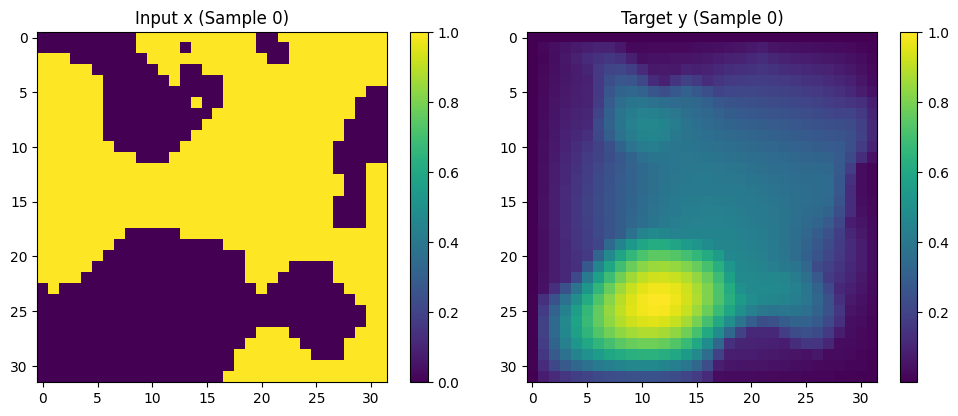

In [22]:
# 샘플 시각화
x_samples, y_samples = batch['x'], batch['y']
sample_idx = 0

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(x_samples[sample_idx].squeeze(), cmap='viridis')
axes[0].set_title(f"Input x (Sample {sample_idx})")
axes[0].figure.colorbar(axes[0].images[0], ax=axes[0])

axes[1].imshow(y_samples[sample_idx].squeeze(), cmap='viridis')
axes[1].set_title(f"Target y (Sample {sample_idx})")
axes[1].figure.colorbar(axes[1].images[0], ax=axes[1])

plt.tight_layout()
plt.show()

In [23]:
# =========================
# 1) Simple CNN (U-Net) Model
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.GroupNorm(num_groups=8, num_channels=out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.GroupNorm(num_groups=8, num_channels=out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    """
    Input : (B, 1, 32, 32)  permeability k
    Output: (B, 1, 32, 32)  pressure u
    """
    def __init__(self, in_ch=1, out_ch=1, base=32, drop=0.0):
        super().__init__()
        self.inc  = DoubleConv(in_ch, base)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base, base*2))   # 32 -> 16
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base*2, base*4)) # 16 -> 8
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base*4, base*8)) # 8 -> 4

        self.mid = DoubleConv(base*8, base*8)

        self.up3 = nn.ConvTranspose2d(base*8, base*4, kernel_size=2, stride=2)  # 4 -> 8
        self.conv3 = DoubleConv(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, kernel_size=2, stride=2)  # 8 -> 16
        self.conv2 = DoubleConv(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, kernel_size=2, stride=2)    # 16 -> 32
        self.conv1 = DoubleConv(base*2, base)

        self.drop = nn.Dropout2d(drop) if drop > 0 else nn.Identity()
        self.outc = nn.Conv2d(base, out_ch, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)          # (B,base,32,32)
        x2 = self.down1(x1)       # (B,2b,16,16)
        x3 = self.down2(x2)       # (B,4b,8,8)
        x4 = self.down3(x3)       # (B,8b,4,4)

        x4 = self.mid(x4)
        x4 = self.drop(x4)

        u3 = self.up3(x4)
        u3 = torch.cat([u3, x3], dim=1)
        u3 = self.conv3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, x2], dim=1)
        u2 = self.conv2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, x1], dim=1)
        u1 = self.conv1(u1)

        return self.outc(u1)

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        if getattr(m, "bias", None) is not None:
            nn.init.zeros_(m.bias)


In [24]:
# =========================
# 2) Training / Evaluation Loop (minimal)
# =========================
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_model = UNet(in_ch=1, out_ch=1, base=32, drop=0.0).to(device)
cnn_model.apply(init_weights)

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

def ensure_4d(x):
    # x: (B,32,32) -> (B,1,32,32)
    if x.ndim == 3:
        return x.unsqueeze(1)
    return x

def rel_l2(u_pred, u_true, eps=1e-12):
    # u: (B,1,H,W)
    num = torch.norm((u_pred - u_true).reshape(u_true.size(0), -1), dim=1)
    den = torch.norm(u_true.reshape(u_true.size(0), -1), dim=1).clamp_min(eps)
    return (num / den).mean().item()

def train_one_epoch(loader):
    cnn_model.train()
    total_loss = 0.0
    for batch in loader:
        x = ensure_4d(batch["x"]).to(device).float()
        y = ensure_4d(batch["y"]).to(device).float()

        pred = cnn_model(x)
        loss = F.mse_loss(pred, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_loader(loader):
    cnn_model.eval()
    total_loss = 0.0
    total_rel = 0.0
    n = 0
    for batch in loader:
        x = ensure_4d(batch["x"]).to(device).float()
        y = ensure_4d(batch["y"]).to(device).float()
        pred = cnn_model(x)
        loss = F.mse_loss(pred, y, reduction="mean").item()
        r = rel_l2(pred, y)

        bs = x.size(0)
        total_loss += loss * bs
        total_rel  += r * bs
        n += bs
    return total_loss / n, total_rel / n


In [7]:
# =========================
# 3) Run Training
# =========================
num_epochs = 100
test_loader = test_loaders[32]
for ep in range(1, num_epochs + 1):
    tr_loss = train_one_epoch(train_loader)
    te_loss, te_rel = eval_loader(test_loader)
    scheduler.step()

    if ep % 10 == 0 or ep == 1:
        print(f"[{ep:03d}] train_mse={tr_loss:.4e} | test_mse={te_loss:.4e} | test_relL2={te_rel:.4f}")
        torch.save(cnn_model.state_dict(), "C:/Users/admin/Desktop/김도형/코드/model/darcy_unet_autosave.pt")


[001] train_mse=5.2849e-02 | test_mse=2.5211e-02 | test_relL2=0.2636
[010] train_mse=5.3646e-03 | test_mse=3.9445e-03 | test_relL2=0.1094
[020] train_mse=1.5114e-03 | test_mse=1.4580e-03 | test_relL2=0.0728
[030] train_mse=7.7300e-04 | test_mse=1.0074e-03 | test_relL2=0.0609
[040] train_mse=7.8699e-04 | test_mse=7.1848e-04 | test_relL2=0.0496
[050] train_mse=5.6164e-04 | test_mse=1.2574e-03 | test_relL2=0.0613
[060] train_mse=3.6565e-04 | test_mse=5.0793e-04 | test_relL2=0.0427
[070] train_mse=4.2537e-04 | test_mse=6.1348e-04 | test_relL2=0.0451
[080] train_mse=2.9607e-04 | test_mse=5.1682e-04 | test_relL2=0.0406
[090] train_mse=3.0453e-04 | test_mse=4.7346e-04 | test_relL2=0.0398
[100] train_mse=3.6010e-04 | test_mse=9.0411e-04 | test_relL2=0.0509


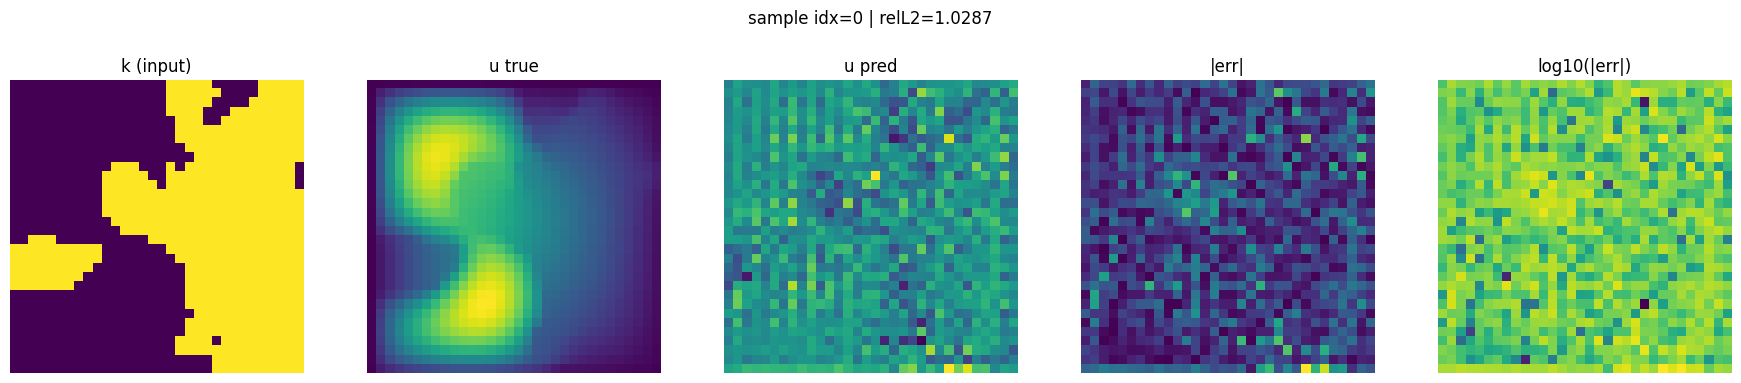

In [25]:
# =========================
# 4) Visualization (k, u_true, u_pred, error, log-error)
# =========================
import matplotlib.pyplot as plt

@torch.no_grad()
def visualize_sample(loader, idx=0, eps=1e-12):
    cnn_model.eval()
    batch = next(iter(loader))
    x = ensure_4d(batch["x"]).float()
    y = ensure_4d(batch["y"]).float()

    # pick sample
    x1 = x[idx:idx+1].to(device)
    y1 = y[idx:idx+1].to(device)
    pred = cnn_model(x1)

    k_np = x1.squeeze().detach().cpu().numpy()       # (H,W)
    u_true = y1.squeeze().detach().cpu().numpy()
    u_pred = pred.squeeze().detach().cpu().numpy()
    err = np.abs(u_pred - u_true)
    log_err = np.log10(err + eps)

    rel = np.linalg.norm((u_pred - u_true).ravel()) / (np.linalg.norm(u_true.ravel()) + eps)

    fig, axs = plt.subplots(1, 5, figsize=(18, 3.6))
    axs[0].imshow(k_np);      axs[0].set_title("k (input)"); axs[0].axis("off")
    axs[1].imshow(u_true);    axs[1].set_title("u true");    axs[1].axis("off")
    axs[2].imshow(u_pred);    axs[2].set_title("u pred");    axs[2].axis("off")
    axs[3].imshow(err);       axs[3].set_title("|err|");     axs[3].axis("off")
    axs[4].imshow(log_err);   axs[4].set_title("log10(|err|)"); axs[4].axis("off")
    plt.suptitle(f"sample idx={idx} | relL2={rel:.4f}", y=1.05)
    plt.tight_layout()
    plt.show()

# 사용 예:
visualize_sample(test_loader, idx=0)


In [ ]:
import torch
import numpy as np

@torch.no_grad()
def print_all_relative_errors(loader, eps=1e-12):
    cnn_model.eval()
    
    sample_idx = 0
    print(f"{'Sample Index':<15} | {'Relative L2 Error (%)':<20}")
    print("-" * 40)

    for batch in loader:
        # 데이터 로드 및 4D 보장
        x = ensure_4d(batch["x"]).to(device).float()
        y = ensure_4d(batch["y"]).to(device).float()
        
        # 모델 예측
        pred = cnn_model(x)
        
        # 배치 내의 각 샘플에 대해 오차 계산
        # (batch_size, 1, H, W) -> (batch_size, H*W) 형태로 펼쳐서 계산하면 편리합니다.
        y_flat = y.view(y.size(0), -1).cpu().numpy()
        pred_flat = pred.view(pred.size(0), -1).cpu().numpy()
        
        for i in range(len(y_flat)):
            true_sample = y_flat[i]
            pred_sample = pred_flat[i]
            
            # L2 상대 오차 계산
            diff_norm = np.linalg.norm(true_sample - pred_sample)
            true_norm = np.linalg.norm(true_sample)
            
            rel_l2 = (diff_norm / (true_norm + eps)) * 100
            
            print(f"Sample {sample_idx:<8} | {rel_l2:.4f}%")
            sample_idx += 1

    print("-" * 40)
    print(f"Total samples processed: {sample_idx}")

# 사용 예:
print_all_relative_errors(test_loader)

Sample Index    | Relative L2 Error (%)
----------------------------------------
Sample 0        | 4.2383%
Sample 1        | 3.1413%
Sample 2        | 5.5817%
Sample 3        | 3.3325%
Sample 4        | 9.6332%
Sample 5        | 6.8772%
Sample 6        | 4.7012%
Sample 7        | 4.5361%
Sample 8        | 3.8237%
Sample 9        | 4.1604%
Sample 10       | 3.1295%
Sample 11       | 3.9891%
Sample 12       | 3.0672%
Sample 13       | 5.5183%
Sample 14       | 7.5793%
Sample 15       | 7.1606%
Sample 16       | 5.1427%
Sample 17       | 4.4168%
Sample 18       | 6.1573%
Sample 19       | 5.5731%
----------------------------------------
Total samples processed: 20



[U-Net] Testing Resolution: 16x16 (Model: C:/Users/admin/Desktop/김도형/코드/model/darcy_unet_autosave.pt)


C:\Users\admin\AppData\Local\Temp\ipykernel_2360\858936738.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


총 테스트 샘플 수: 20
전체 샘플 Relative L2 Error: ['13.08%', '11.71%', '11.06%', '10.81%', '16.86%', '12.09%', '16.04%', '11.27%', '12.29%', '12.95%', '10.24%', '12.24%', '09.40%', '21.46%', '14.81%', '16.81%', '13.46%', '16.26%', '12.88%', '10.91%']
평균 Relative L2 Error: 13.33%


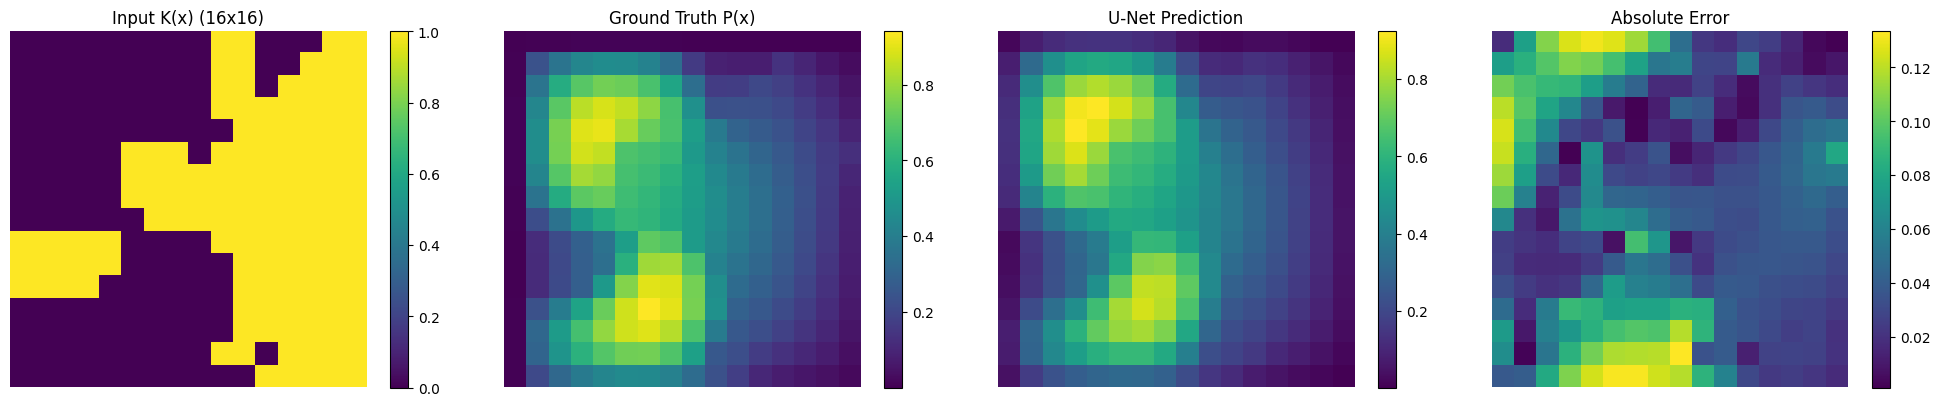

------------------------------------------------------------

[U-Net] Testing Resolution: 32x32 (Model: C:/Users/admin/Desktop/김도형/코드/model/darcy_unet_autosave.pt)
총 테스트 샘플 수: 20
전체 샘플 Relative L2 Error: ['04.24%', '03.14%', '05.58%', '03.33%', '09.63%', '06.88%', '04.70%', '04.54%', '03.82%', '04.16%', '03.13%', '03.99%', '03.07%', '05.52%', '07.58%', '07.16%', '05.14%', '04.42%', '06.16%', '05.57%']
평균 Relative L2 Error: 5.09%


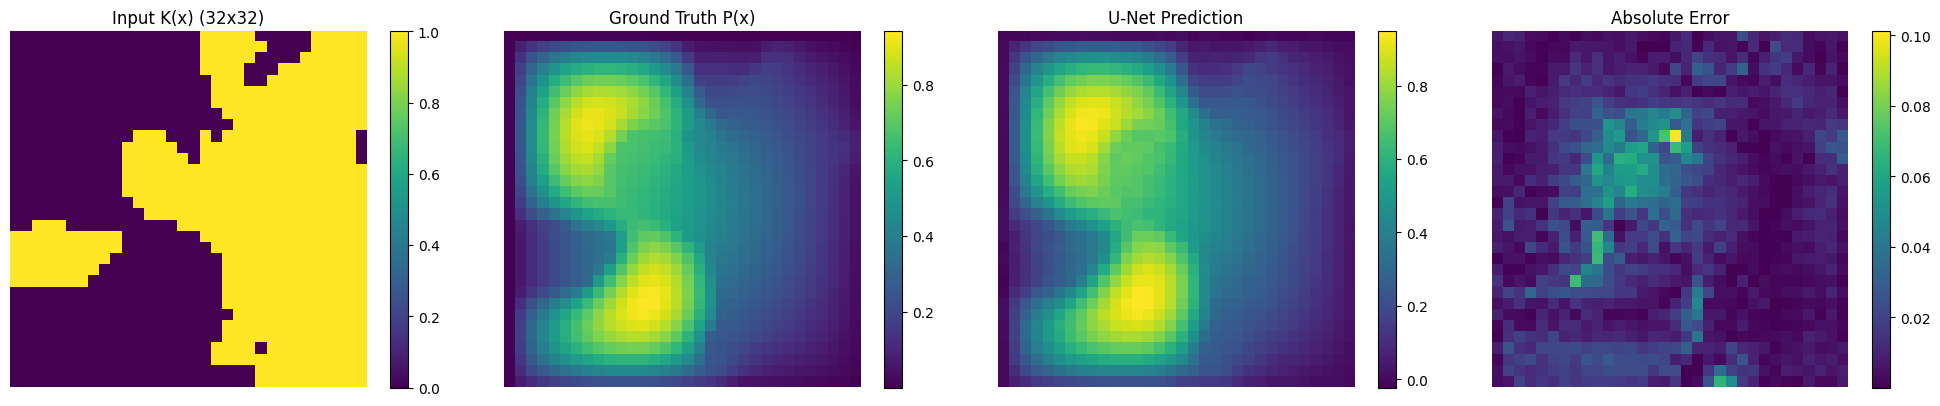

------------------------------------------------------------

[U-Net] Testing Resolution: 64x64 (Model: C:/Users/admin/Desktop/김도형/코드/model/darcy_unet_autosave.pt)
총 테스트 샘플 수: 20
전체 샘플 Relative L2 Error: ['05.69%', '05.99%', '08.10%', '07.15%', '13.33%', '12.69%', '07.12%', '06.74%', '07.18%', '07.42%', '06.20%', '05.82%', '04.82%', '07.95%', '16.01%', '08.88%', '07.86%', '08.33%', '06.10%', '14.91%']
평균 Relative L2 Error: 8.41%


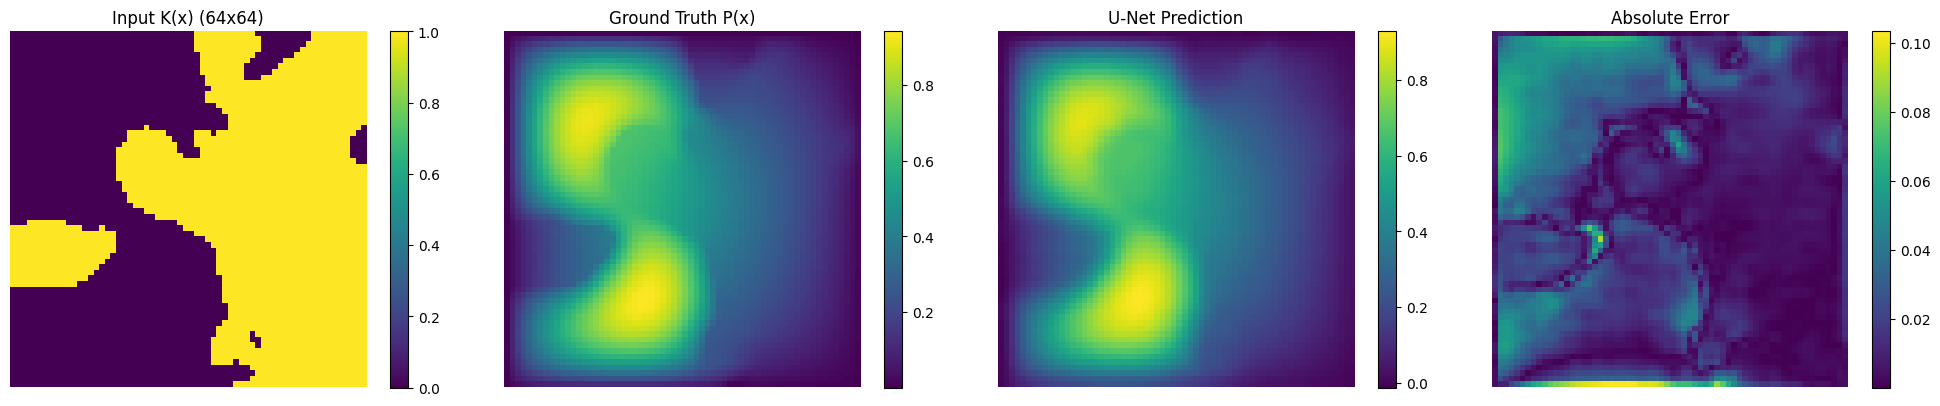

------------------------------------------------------------

[U-Net] Testing Resolution: 128x128 (Model: C:/Users/admin/Desktop/김도형/코드/model/darcy_unet_autosave.pt)
총 테스트 샘플 수: 20
전체 샘플 Relative L2 Error: ['07.82%', '08.23%', '08.43%', '08.16%', '13.52%', '14.49%', '07.99%', '07.48%', '09.39%', '08.78%', '08.76%', '06.53%', '05.65%', '07.91%', '18.87%', '09.53%', '09.12%', '10.23%', '06.52%', '16.30%']
평균 Relative L2 Error: 9.69%


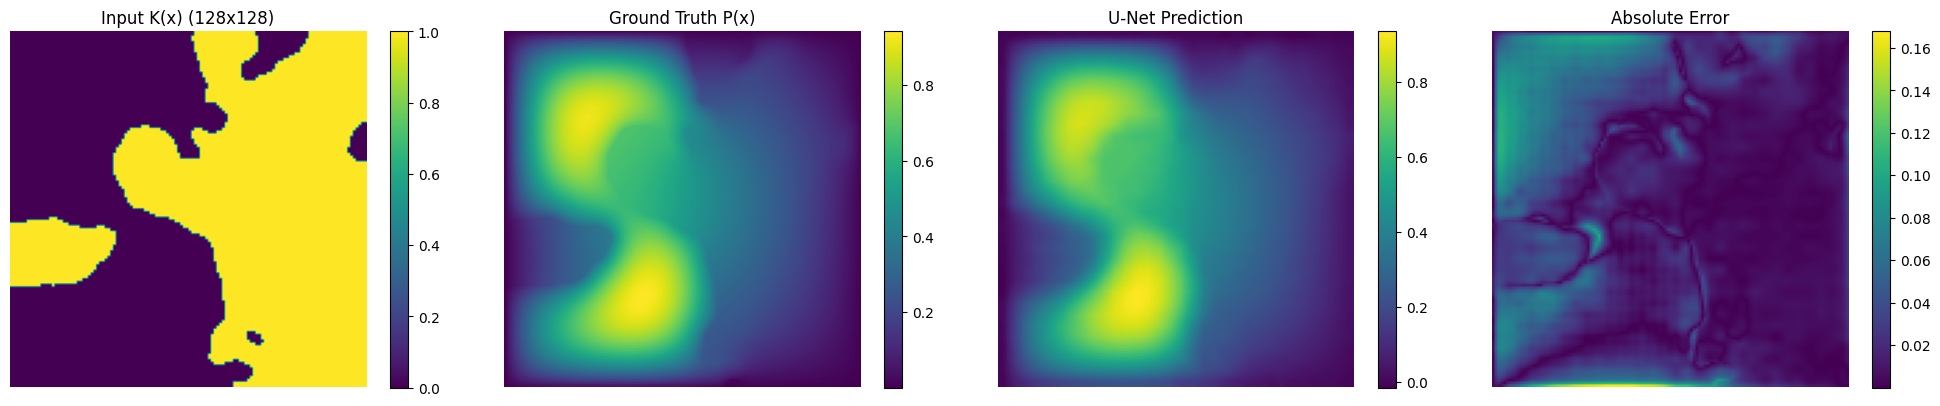

------------------------------------------------------------


In [32]:
import torch.nn.functional as F
def test_unet(model_path, resolution, data_loader):
    print(f"\n[U-Net] Testing Resolution: {resolution}x{resolution} (Model: {model_path})")
    
    # 모델 초기화
    model = UNet(in_ch=1, out_ch=1, base=32, drop=0.0).to(device)
    
    # 가중치 로드
    try:
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint)
        model.eval()
    except Exception as e:
        print(f"모델 로드 실패: {e}")
        return

    l2_errors = []
    vis_input, vis_true, vis_pred = None, None, None
    
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            # 입력 데이터 (B, 1, Res, Res)
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            
            # --- 해상도 보정 (CNN 입력 고정: 32x32) ---
            if x.shape[-1] != 32:
                x_in = F.interpolate(x, size=(32, 32), mode='bilinear', align_corners=False)
            else:
                x_in = x
                
            # 예측 (Output: 32x32)
            out = model(x_in)
            
            # --- 출력을 원래 해상도로 복원 ---
            if out.shape[-1] != resolution:
                out_resized = F.interpolate(out, size=(resolution, resolution), mode='bilinear', align_corners=False)
            else:
                out_resized = out
            
            # 오차 계산
            pred_flat = out_resized.view(out_resized.size(0), -1)
            true_flat = y.view(y.size(0), -1)
            
            diff_norm = torch.norm(pred_flat - true_flat, p=2, dim=1)
            true_norm = torch.norm(true_flat, p=2, dim=1)
            batch_errors = diff_norm / (true_norm + 1e-6)
            
            l2_errors.extend(batch_errors.cpu().tolist())
            
            # 시각화용 샘플 저장 (첫 배치 첫 샘플)
            if i == 0:
                vis_input = x[0, 0].cpu().numpy()
                vis_true = y[0, 0].cpu().numpy()
                vis_pred = out_resized[0, 0].cpu().numpy()

    # 결과 출력
    avg_error = np.mean(l2_errors)
    print(f"총 테스트 샘플 수: {len(l2_errors)}")
    formatted_errors = [f"{e*100:05.2f}%" for e in l2_errors]
    print(f"전체 샘플 Relative L2 Error: {formatted_errors}")
    print(f"평균 Relative L2 Error: {avg_error*100:.2f}%")
    
    # 시각화
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    abs_error = np.abs(vis_true - vis_pred)
    
    titles = [f'Input K(x) ({resolution}x{resolution})', 
              'Ground Truth P(x)', 
              'U-Net Prediction', 
              'Absolute Error']
    images = [vis_input, vis_true, vis_pred, abs_error]
    
    for ax, img, title in zip(axes, images, titles):
        im = ax.imshow(img, cmap='viridis')
        ax.set_title(title)
        plt.colorbar(im, ax=ax)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"C:/Users/admin/Desktop/김도형/코드/figure_20260213_labmeeting/result_u-net_sample_{resolution}.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("-" * 60)

# ==========================================
# 3. 실행
# ==========================================
model_file = "C:/Users/admin/Desktop/김도형/코드/model/darcy_unet_autosave.pt"

test_unet(model_file, 16, test_loaders[16])
test_unet(model_file, 32, test_loaders[32])
test_unet(model_file, 64, test_loaders[64])
test_unet(model_file, 128, test_loaders[128])